#  Credit score classifier

In this project, we will be attempting to create a classifier for predicting the credit score of a customer (Good or Bad), given his/her application data.

The data is provided by the Central Chinese Bank and has been anonimized.

This notebook is sctructured as follows:
* **Library loading**: Libraries used in the analysis are loaded.
* **Data import**: Automatic data reading from github.
* **Basic Variables inspection**: Variable inspection and some basic statistics.
* **Labels**: Process for creating labels in the data, based on Vintage analysis.
* **Merging of datasets**: The application dataset is merged with the credit score dataset.
* **Missing values**: Exploration of missing values and imputation
* **Exploratory Data analysis**: Univariate and bivariate analyses for the data are presented.
* **Feature engineering**: New features are created.
* **Feature Selection**: Features for the models are selected.
* **Fixing the class imbalance**: Upsampling is used to create a balanced dataset.
* **Model development and tuning**: ML models are developed and gridSearch is performed.
* **Model Evaluation**: Models are evaluated on the dev set.
* **Model Testing**: Model being tested on test set
* **Conclusion**: Discussion about results and limitations

# Library loading

In [1]:
## General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Correlation-related
import ppscore as pps

## Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## preprocessing
from sklearn.preprocessing import MinMaxScaler

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

## Imbalance
from imblearn.over_sampling import SMOTE

##Cross validation for imbalanced data
from sklearn.model_selection import PredefinedSplit


# Data import from github

In [2]:
credit_data = pd.read_csv("https://raw.githubusercontent.com/jmoschos/Credit-score-approval/master/credit_record.csv")

In [3]:
app_data = pd.read_csv("https://raw.githubusercontent.com/jmoschos/Credit-score-approval/master/application_record.csv")

# Basic variable inspection

In [4]:
credit_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
len(app_data)

438557

In [7]:
len(credit_data)

1048575

# Labels 
In the dataset, no labels are given for "good" and "bad" customers. We will attempt to create new labels based on a vintage analysis. 

### Vintage analysis
In vintage analysis, if a customer defaults (90 days or more past due) during the performance window, the borrower will be considered as a 'bad' customer and labeled as '1' in the dependent variable.

In our dataset, the status is flagged as:
* 0 for 0-29 days
* 1 for 30-59 days
* 2 for 60-89 days
* 3 for 90-119 days
* 4 for 120-149 days
* 5 for 150+ days
* X for no Loan this month
* C for paid this month

If a user has more than 90 days overdue, we are going to flag him as "bad". Therefore, 0,1,2,X,C will be labelled as good and the rest as bad.

First, lets check the distribution amongst different categories:

In [8]:
## Percentage of records per status category
credit_data.groupby(["STATUS"]).agg(percent_per_category = ("STATUS","count"))*100/len(credit_data)

,percent_per_category
STATUS,
0,36.537205
1,1.057626
2,0.082779
3,0.030518
4,0.021267
5,0.161457
C,42.155401
X,19.953747


**Observation**: Majority of users are in the 0, C and X categories. 

Since the user (credit_score) file has multiple observations for each user, we are going to extract the initial month for each user. The initial month is a negative number indicating how many months before today, the account was opened. We should note that knowing the application date might have provided additional info for our users.

In [9]:
# Finding the initial month for each user, as the minimum month in Balance grouped by user
initial_month_df = credit_data.groupby("ID").agg(
    initial_month = ("MONTHS_BALANCE",min)
)

In [10]:
# Merging the initial month with the existing dataset
credit_initial = pd.merge(credit_data,initial_month_df,how = "left", on=["ID"])

In [11]:
# Labeling all users belonging in group 4 or 5 as "Bad"
credit_initial["Label"]= np.where((credit_initial.STATUS == "4") | (credit_initial.STATUS =="5"), 1 , 0 )

In [12]:
credit_initial

,ID,MONTHS_BALANCE,STATUS,initial_month,Label
0,5001711,0,X,-3,0
1,5001711,-1,0,-3,0
2,5001711,-2,0,-3,0
3,5001711,-3,0,-3,0
4,5001712,0,C,-18,0
...,...,...,...,...,...
1048570,5150487,-25,C,-29,0
1048571,5150487,-26,C,-29,0
1048572,5150487,-27,C,-29,0
1048573,5150487,-28,C,-29,0


**Note**: A user can have multiple labels in the current dataset. For example, he can be labeled as "good" for the first 4 months and then due to missing payments, the label can change to "bad". Ultimately, as the goal of the study is to identify "bad" customers from the application data, we need only one label for each user. This will be the following section (Finalizing labels for each user).

In the following graph, the distribution of initial month is presented for each user. 

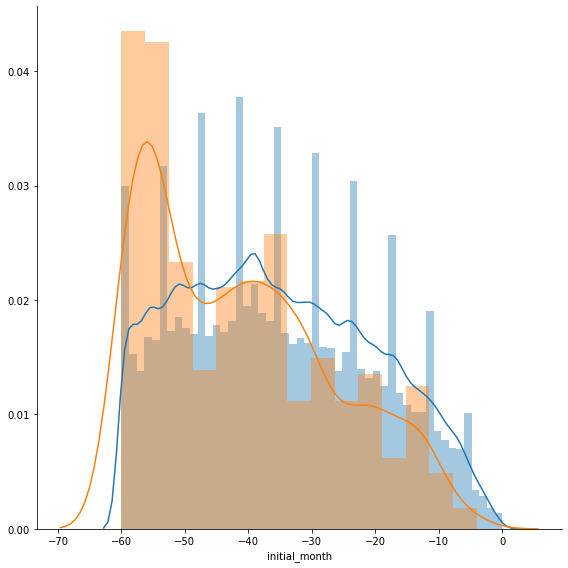

In [13]:
# Histograms for each label group.
g = sns.FacetGrid(credit_initial, hue = "Label", height=8)
g = g.map(sns.distplot, "initial_month")

**Observation** While both the good and bad customers follow similar distributions, we see a huge spike on accounts that are 50 or more months old. These could potentially be test accounts used by the bank for operations.

We could theoretically exclude them from the analysis, but given that we have no insight that this is the actual case, we will not.

## Finalizing the labels for each user

Since each user can default at any moment in time, we will characterize him as bad if he had defaulted at least once in his time with the bank.

In [14]:
## Creation of table to merge with application data:

credit_to_merge = credit_initial.groupby(["ID"]).agg(
    initial_month = ("MONTHS_BALANCE",min),
    Label = ("Label",max)

)

In [15]:
credit_to_merge

,initial_month,Label
ID,,
5001711,-3,0
5001712,-18,0
5001713,-21,0
5001714,-14,0
5001715,-59,0
...,...,...
5150482,-28,0
5150483,-17,0
5150484,-12,0


In [16]:
print('The percentage of "bad customers" is: ',100*sum(credit_to_merge.Label)/len(credit_to_merge), "%")

The percentage of "bad customers" is:  0.5284331847341525 %


The dataset is very unbalanced, and will have to adjust for that later.

## Merging of datasets



We are going to merge the two tables by "ID" and keep only users who have been labeled in the previous steps.

In [17]:
data = pd.merge(app_data,credit_to_merge,on = "ID", how = "right")

In [18]:
data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,initial_month,Label
0,5008804,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,-15,0
1,5008805,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,-14,0
2,5008806,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,-29,0
3,5008808,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-4,0
4,5008809,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,5122361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5,0
45981,5122362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5,0
45982,5122363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9,0
45983,5122364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-41,0


## Missing values

We are now going to check for missing values:

In [19]:
missing = data.isnull().sum(axis = 1)

Since the data is so unbalanced, "good" customers missing a lot of data can be safely dropped. However, for customers characterized as "bad" (due to their number), we have to check if they can be "salvaged".

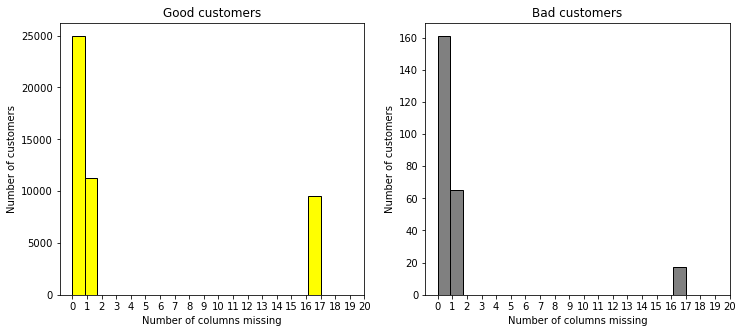

In [20]:
## Histplot for good and bad customers, bins = number of columns
plt.figure(figsize=(12,5))

ax1 = plt.subplot(1,2,1)
ax1.hist(missing[data.Label ==0],bins = 20,edgecolor = "black", color = "yellow")
plt.title("Good customers")
plt.xlabel("Number of columns missing")
plt.ylabel("Number of customers")
plt.xticks(ticks=np.arange(0,21,1))

ax2 = plt.subplot(1,2,2)
ax2.hist(missing[data.Label ==1],bins = 20,edgecolor = "black",color = "grey")

plt.title("Bad customers")
plt.xlabel("Number of columns missing")
plt.ylabel("Number of customers")
plt.xticks(ticks=np.arange(0,21,1))
plt.show()

The application data consists of 18 fields, including the ID. Since the credit data did not contain any missing values, the above histograms refers only to the application data. All the customers with 17 missing columns essentially have no application data, and thus cannot be utilized in our analysis.

In [21]:
print("The number of bad customers with all application data missing is: ", sum((missing >= 17) & (data.Label ==1)))
print("The number of good customers with all application data missing is: ", sum((missing >= 17) & (data.Label ==0)))

The number of bad customers with all application data missing is:  17
The number of good customers with all application data missing is:  9511


We are going to drop the rows (both good and bad customers) that have all the data missing and we are going to fix those that have only 1 column missing.

In [22]:
new_data = data.drop(data[missing>=17].index)

In [23]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,initial_month,Label
0,5008804,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,-15,0
1,5008805,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,-14,0
2,5008806,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,-29,0
3,5008808,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-4,0
4,5008809,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0.0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348.0,-2420.0,1.0,0.0,0.0,0.0,Managers,2.0,-11,1
36453,5149834,F,N,Y,0.0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-23,1
36454,5149838,F,N,Y,0.0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-32,1
36455,5150049,F,N,Y,0.0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0.0,0.0,0.0,Sales staff,2.0,-9,0


Let's observe how NA values are distributed amongst the fiels:

In [24]:
new_data.isna().sum(axis = 0)

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
initial_month              0
Label                      0
dtype: int64

**Observation** Only the occupation type has missing values from all the columns. It appears that the bank always captures the rest of information for their clients (assuming it captures any info). 

Unique occupation categories:

In [25]:
new_data.OCCUPATION_TYPE.unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

As there is a lot of missing data in the occupation, we are going to treat NAs as a unique category in our analysis!This could imply that the person is simply not working during his application etc. 

In [26]:
new_data.OCCUPATION_TYPE = new_data.OCCUPATION_TYPE.fillna(value="Missing")

In [27]:
sum(new_data.OCCUPATION_TYPE.isna())

0

In [28]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,initial_month,Label
0,5008804,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Missing,2.0,-15,0
1,5008805,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Missing,2.0,-14,0
2,5008806,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,-29,0
3,5008808,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-4,0
4,5008809,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0.0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348.0,-2420.0,1.0,0.0,0.0,0.0,Managers,2.0,-11,1
36453,5149834,F,N,Y,0.0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-23,1
36454,5149838,F,N,Y,0.0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-32,1
36455,5150049,F,N,Y,0.0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0.0,0.0,0.0,Sales staff,2.0,-9,0


#  Exploratory Data analysis

In this section, we will explore the different variables and the relationship with our target variable.

Lets start by dropping the ID and initial_month variables that will not be needed for our models.

In [29]:
new_data = new_data.drop(["ID","initial_month"],axis = 1)
new_data

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Label
0,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Missing,2.0,0
1,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Missing,2.0,0
2,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,0
4,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,M,Y,Y,0.0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348.0,-2420.0,1.0,0.0,0.0,0.0,Managers,2.0,1
36453,F,N,Y,0.0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,1
36454,F,N,Y,0.0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,1
36455,F,N,Y,0.0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0.0,0.0,0.0,Sales staff,2.0,0


In [30]:
## Finding unique labels, and splitting dataset based on those values
unique_labels = new_data.Label.unique()
labels = [new_data[new_data.Label == val] for val in unique_labels]

In [31]:
my_colors = ["denim blue","pale red"]

## Gender analysis 

Let's begin by examining the number of genders in the application data. 

In [32]:
unique_genders = new_data.CODE_GENDER.unique() ## just making sure only 2 genders exist
print(unique_genders)

['M' 'F']


In [33]:
# Saving datasets based on gender
genders = [new_data[new_data.CODE_GENDER==gender] for gender in unique_genders]
    

In [34]:
for gender in genders:
    print("Gender: ", gender.CODE_GENDER.unique())
    print("Number of customers:", len(gender))
    print("Percentage of good customers", sum(gender.Label ==0)/len(gender))
    print("Percentage of bad customers", sum(gender.Label == 1)/len(gender))

Gender:  ['M']
Number of customers: 12027
Percentage of good customers 0.9921842520994429
Percentage of bad customers 0.00781574790055708
Gender:  ['F']
Number of customers: 24430
Percentage of good customers 0.994596807204257
Percentage of bad customers 0.005403192795742939


**Observation** Men appear slightly more prone to defaulting than women, but they also consist of 1/3 of the total population.

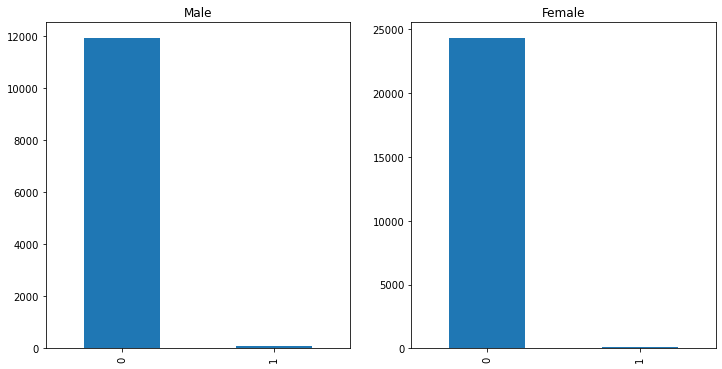

In [35]:
nrows = 1
ncols = 2

# Here axes contains 2 objects representing the two subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))

for i,gender in enumerate(genders):
    gender['Label'].value_counts().plot(kind = 'bar', ax = axes[i])
    axes[i].set_title("Male" if gender.CODE_GENDER.unique() == "M" else "Female")

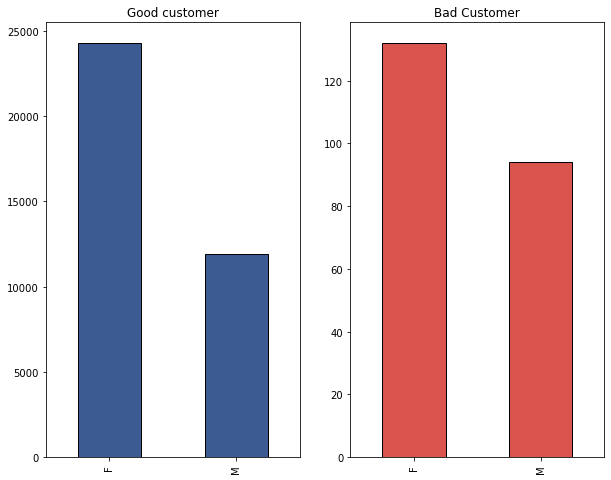

In [36]:
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows,ncols,figsize = (10,8))

for i,label in enumerate(labels):
    label.CODE_GENDER.value_counts().plot(kind = "bar", ax = axes[i],color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if(label.Label.unique()==0) else "Bad Customer")

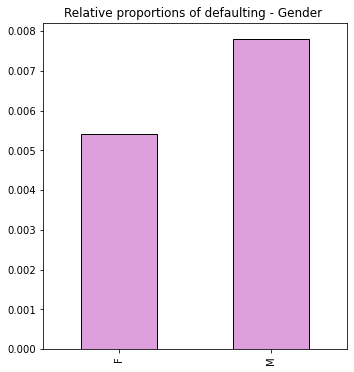

In [37]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
(new_data[new_data["Label"]==1]["CODE_GENDER"].value_counts()/new_data["CODE_GENDER"].value_counts()).plot(kind = "bar",color = "plum",edgecolor = "black",ax = ax1)
ax1.set_title("Relative proportions of defaulting - Gender ")
plt.show()

## Having a car 

Similarly, for car ownership, we are going to check how it affects defaulting rates.

In [38]:
unique_cars = new_data.FLAG_OWN_CAR.unique()
print(unique_cars)
cars = [new_data[new_data.FLAG_OWN_CAR==car] for car in unique_cars]

['Y' 'N']


In [39]:

for car in cars:
    print("Has Car: ", car.FLAG_OWN_CAR.unique())
    print("Number of customers:", len(car))
    print("Percentage of good customers", sum(car.Label ==0)/len(car))
    print("Percentage of bad customers", sum(car.Label == 1)/len(car))

Has Car:  ['Y']
Number of customers: 13843
Percentage of good customers 0.9942931445495918
Percentage of bad customers 0.0057068554504081485
Has Car:  ['N']
Number of customers: 22614
Percentage of good customers 0.9934996020164499
Percentage of bad customers 0.006500397983550013


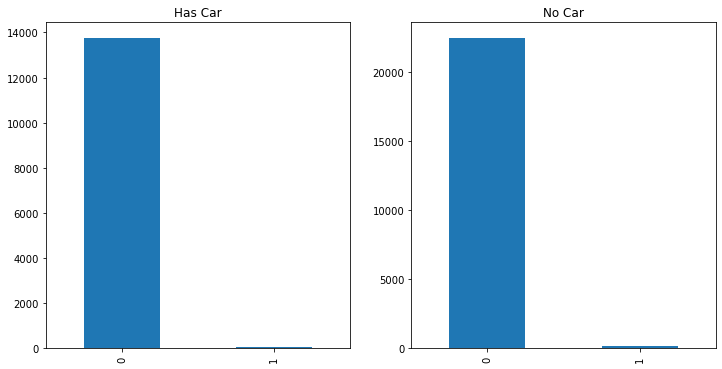

In [40]:
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows,ncols,figsize =(12,6))

for i,car in enumerate(cars):
    car.Label.value_counts().plot(kind = "bar", ax = axes[i])
    axes[i].set_title("Has Car" if(car.FLAG_OWN_CAR.unique()=="Y") else "No Car")
    
plt.show()

**Observation** Not having a car is associated with slightly more bad customers.

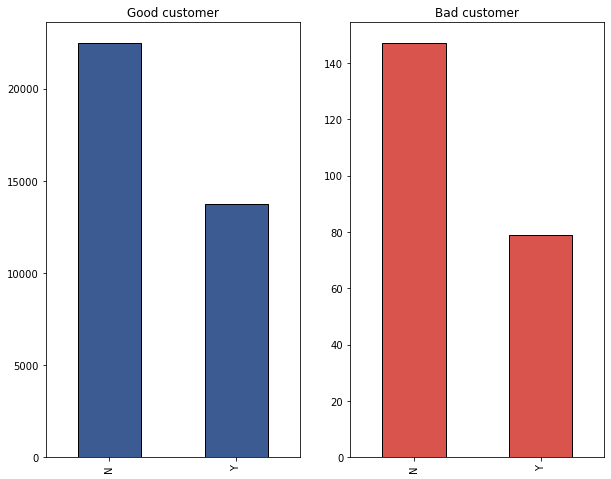

In [41]:
nrow = 1
ncol = 2

fig, axes = plt.subplots(nrow,ncol, figsize = (10,8))

for i,label in enumerate(labels):
    label.FLAG_OWN_CAR.value_counts().plot(kind = "bar", ax = axes[i],color = sns.xkcd_rgb[my_colors[i]], edgecolor = "black")
    axes[i].set_title("Good customer" if label.Label.unique()==0 else "Bad customer")

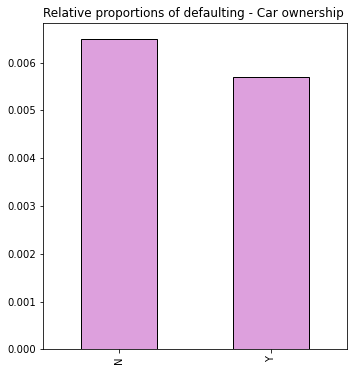

In [42]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
(new_data[new_data["Label"]==1]["FLAG_OWN_CAR"].value_counts()/new_data["FLAG_OWN_CAR"].value_counts()).plot(kind = "bar",color = "plum",edgecolor = "black",ax = ax1)
ax1.set_title("Relative proportions of defaulting - Car ownership ")
plt.show()

### Having a property

In [43]:
unique_properties = new_data.FLAG_OWN_REALTY.unique()
properties = [new_data[new_data.FLAG_OWN_REALTY == val] for val in unique_properties]

In [44]:
for val in properties:
    print("Has Car: ", val.FLAG_OWN_REALTY.unique())
    print("Number of customers:", len(val))
    print("Good customers percentage:",val.Label[val.Label ==0].count()/len(val))
    print("Bad customers percentage:",val.Label[val.Label ==1].count()/len(val))

Has Car:  ['Y']
Number of customers: 24506
Good customers percentage: 0.9942463070268506
Bad customers percentage: 0.005753692973149433
Has Car:  ['N']
Number of customers: 11951
Good customers percentage: 0.9928876244665719
Bad customers percentage: 0.007112375533428165


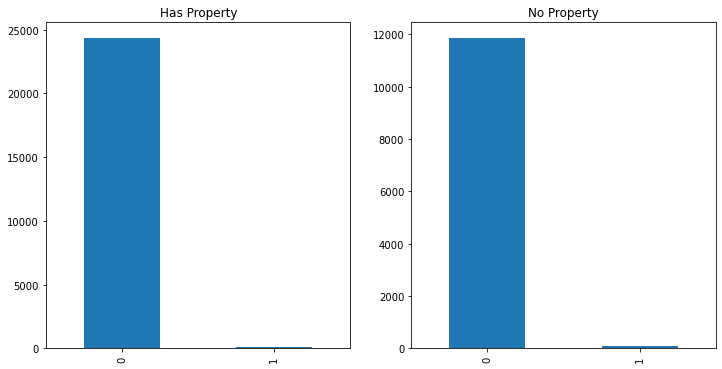

In [45]:
nrow = 1
ncol = 2

fig, axes = plt.subplots(nrows=nrow,ncols=ncol,figsize=(12,6))

for i,val in enumerate(properties):
    val.Label.value_counts().plot(kind = "bar", ax = axes[i])
    axes[i].set_title("Has Property" if(val.FLAG_OWN_REALTY.unique()=="Y") else "No Property")

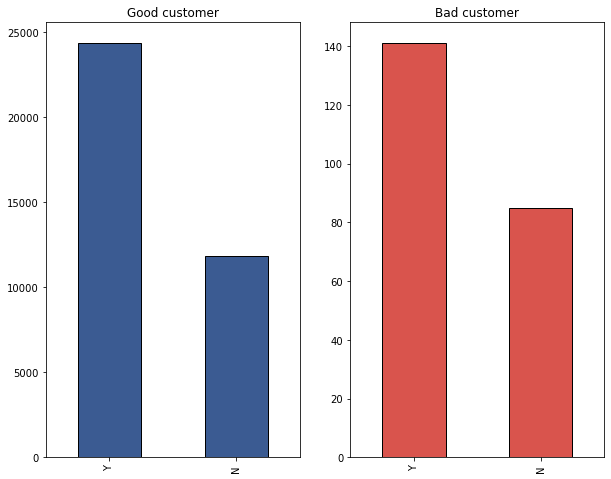

In [46]:
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows,ncols,figsize = (10,8))

for i,label in enumerate(labels):
    label.FLAG_OWN_REALTY.value_counts().plot(kind = "bar", ax = axes[i],color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label.Label.unique()==0 else "Bad customer")

**Observation** Not having an estate is associated with slightly more "bad" customers.

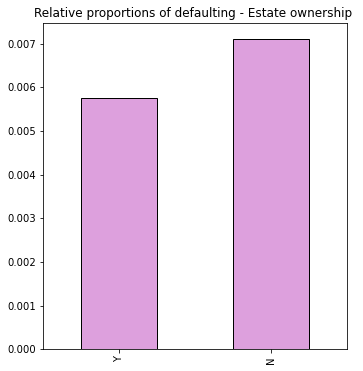

In [47]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
(new_data[new_data["Label"]==1]["FLAG_OWN_REALTY"].value_counts()/new_data["FLAG_OWN_REALTY"].value_counts()).plot(kind = "bar",color = "plum",edgecolor = "black",ax = ax1)
ax1.set_title("Relative proportions of defaulting - Estate ownership ")
plt.show()

### Number of children

For the number of children, we are going to inspect the different values, and try to group together more rare values.

In [48]:
unique_children = new_data.CNT_CHILDREN.unique()
unique_children = np.sort(unique_children)
print(unique_children)

[ 0.  1.  2.  3.  4.  5.  7. 14. 19.]


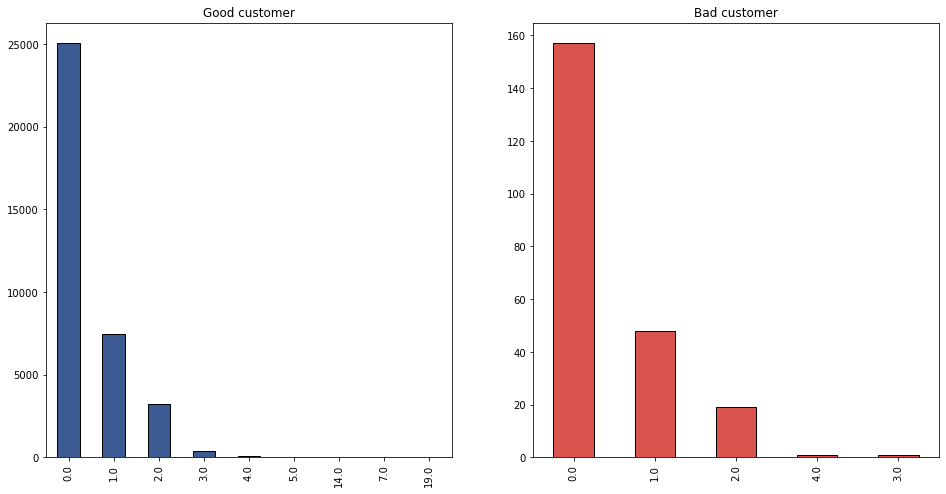

In [49]:
nrows = 1
ncols = len(unique_labels)

fig,axes = plt.subplots(nrows,ncols, figsize = (16,8))

for i,label in enumerate(unique_labels):
    new_data[new_data.Label == label].CNT_CHILDREN.value_counts().plot(kind = "bar",ax = axes[i],color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label == 0 else "Bad customer")

**Observation** Number of children appears to have some strange values (14, 19) and very few observations for them. We are going to convert the number of children to a categorical feature and for all values >=4 convert them to "4+".

In [50]:
new_data.CNT_CHILDREN = np.where(new_data.CNT_CHILDREN>=4, "4+" ,new_data.CNT_CHILDREN)

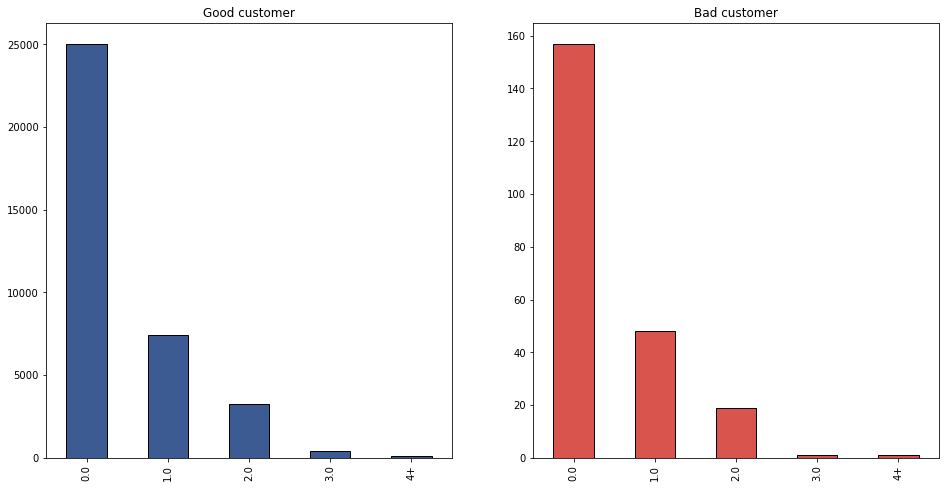

In [51]:
nrows = 1
ncols = len(unique_labels)

fig,axes = plt.subplots(nrows,ncols, figsize = (16,8))

for i,label in enumerate(unique_labels):
    new_data[new_data.Label == label].CNT_CHILDREN.value_counts().plot(kind = "bar",ax = axes[i],color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label == 0 else "Bad customer")

red


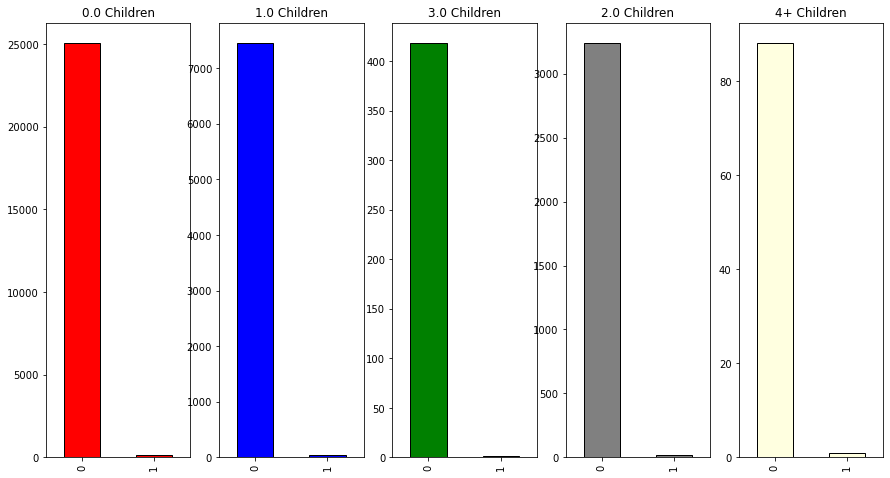

In [52]:
colors = ['red','blue','green','grey','lightyellow']
print(colors[0])
unique_children = new_data["CNT_CHILDREN"].unique()
nrows = 1
ncols = len(unique_children)

fig,axes = plt.subplots(nrows,ncols,figsize = (15,8))

for i, child in enumerate(unique_children):
    new_data[new_data["CNT_CHILDREN"] == child]["Label"].value_counts().plot(kind = "bar", ax = axes[i],color = colors[i],edgecolor = "black")
    axes[i].set_title(child + " Children")

**Observation** While the distributions for the two labels in terms of (number of) children appears to be similar, higher number of children is associated with higher default rates.

Due to the imbalanced dataset, its hard to spot the differences between categories in a grouped plot:

<BarContainer object of 5 artists>

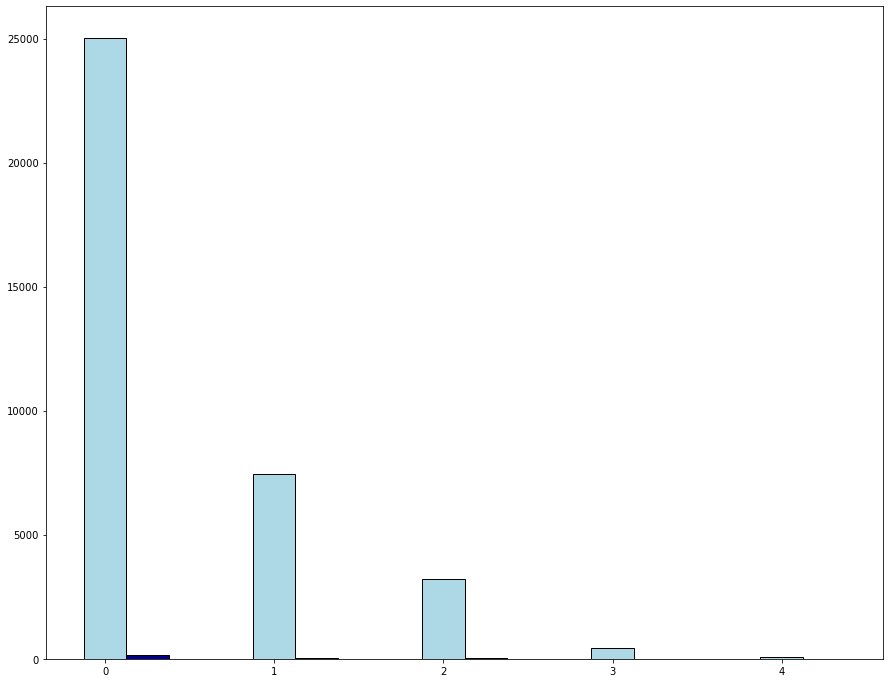

In [53]:
plt.figure(figsize = (15,12))

bars1 = new_data[new_data.Label==0].CNT_CHILDREN.value_counts().to_numpy()
bars2 = new_data[new_data.Label==1].CNT_CHILDREN.value_counts().to_numpy()

barWidth = 0.25
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='lightblue', width=barWidth, label='var1',edgecolor = "black")
plt.bar(r2, bars2, color='darkblue', width=barWidth,  label='var2',edgecolor = "black")


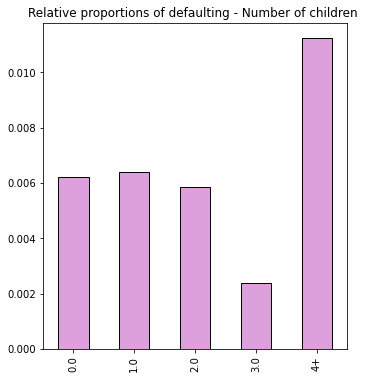

In [54]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
(new_data[new_data["Label"]==1]["CNT_CHILDREN"].value_counts()/new_data["CNT_CHILDREN"].value_counts()).plot(kind = "bar",color = "plum",edgecolor = "black",ax = ax1)
ax1.set_title("Relative proportions of defaulting - Number of children ")
plt.show()

**Observation**:Interistingly while having 3 children is associated with much lower default rates, having any children above that increases the rate fivefold.

### Annual income

For the annual income, we are going to plot the entire distribution, as well as the deviations.

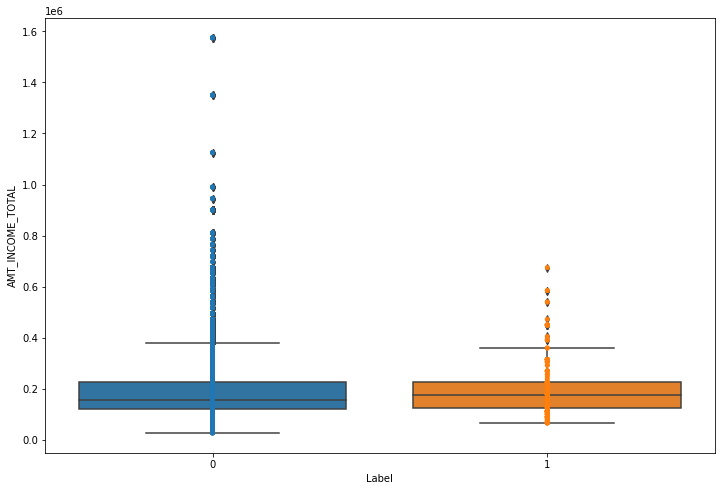

In [55]:
plt.figure(figsize = (12,8))
ax = sns.boxplot(x = new_data["Label"], y = new_data["AMT_INCOME_TOTAL"] )
ax = sns.stripplot(x = new_data.Label, y = new_data.AMT_INCOME_TOTAL, jitter = 0)

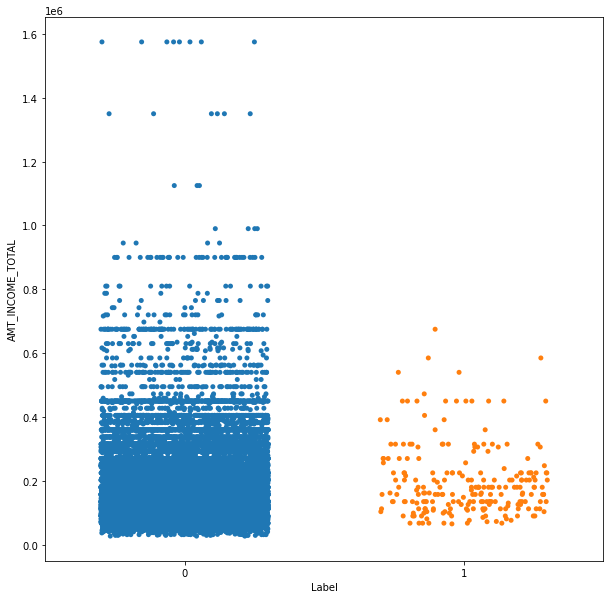

In [56]:
plt.figure(figsize=(10,10))
sns.stripplot(x = new_data.Label, y = new_data.AMT_INCOME_TOTAL, jitter = 0.3)

**Observation** It looks like lower incomes are associated more with "bad" customer rates.

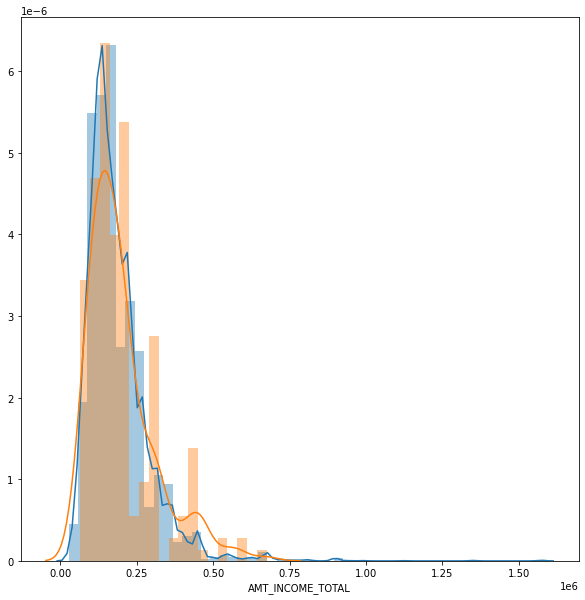

In [57]:
plt.figure(figsize=(10,10))

for label in unique_labels:
    sns.distplot(new_data.AMT_INCOME_TOTAL[new_data.Label==label])

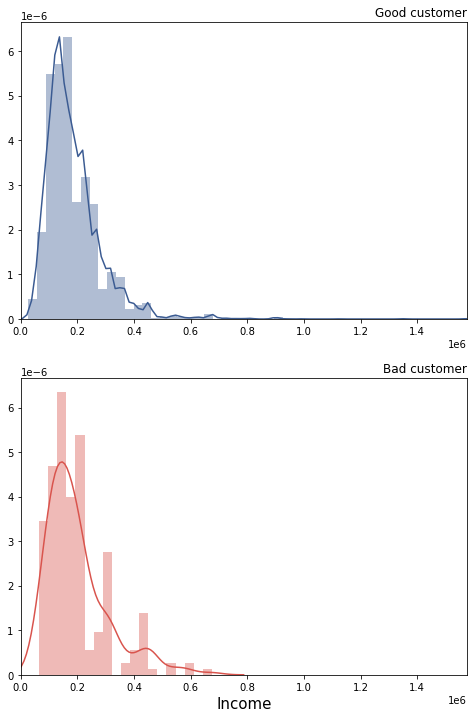

In [58]:
nrows = 2
ncols = 1

fig,axes = plt.subplots(nrows,ncols,figsize = (8,12))

for i, label in enumerate(unique_labels):
    sns.distplot(new_data.AMT_INCOME_TOTAL[new_data["Label"]==label],ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_xlim(0,max(new_data["AMT_INCOME_TOTAL"]))
    axes[i].set_title("Good customer" if label ==0 else "Bad customer", loc = "right")
    axes[i].set_xlabel("Income" if label ==1 else "", fontsize = 15)

**Observation** Customers with more than 800.000 income never default.

### Income type

Continuing with the different income types:

In [59]:
unique_income = new_data.NAME_INCOME_TYPE.unique()
unique_income

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

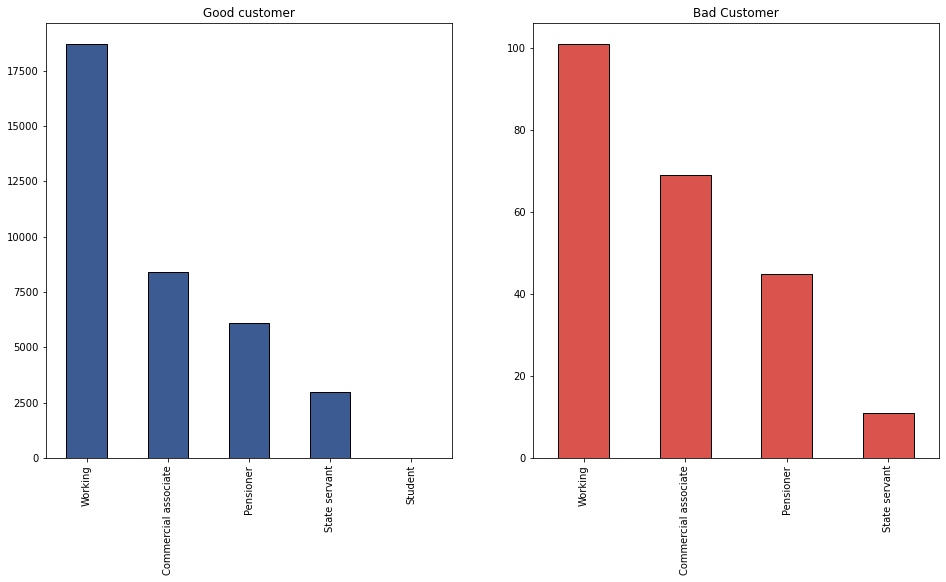

In [60]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols,figsize = (16,8))

for i,label in enumerate(unique_labels):
    new_data[new_data["Label"]==label]["NAME_INCOME_TYPE"].value_counts().plot(kind = "bar", ax = axes[i],color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label==0 else "Bad Customer")

**Observation** There are only a few students, and none of them is associated with defaulting. Additionally, from the data,we can see that State servants are less likely to default and Commercial assosiates and Pensioners are more likely.

Since the income type is directly related to the income, we will also explore the relationship of the two.

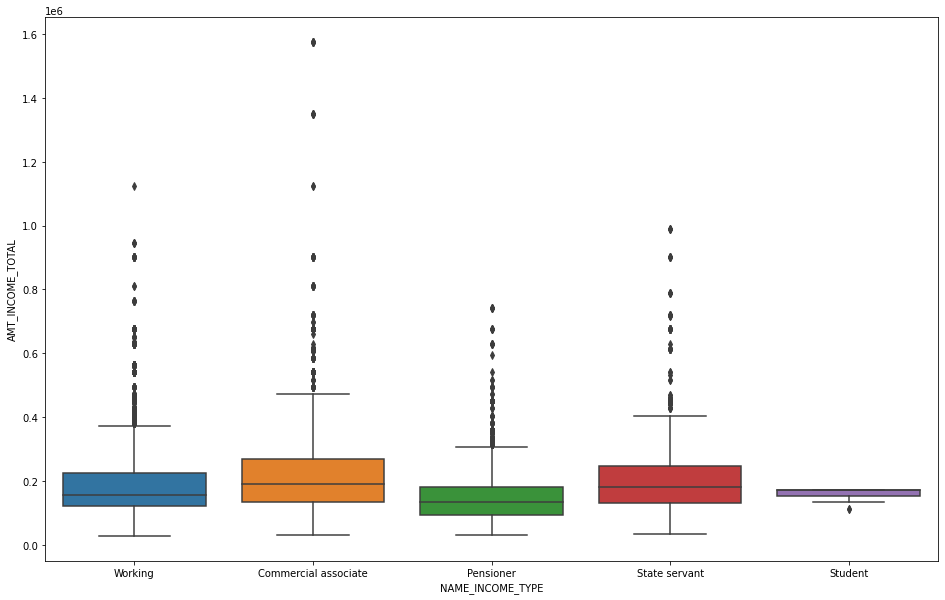

In [61]:
plt.figure(figsize = (16,10))
ax = sns.boxplot(x=new_data["NAME_INCOME_TYPE"], y = new_data["AMT_INCOME_TOTAL"] )

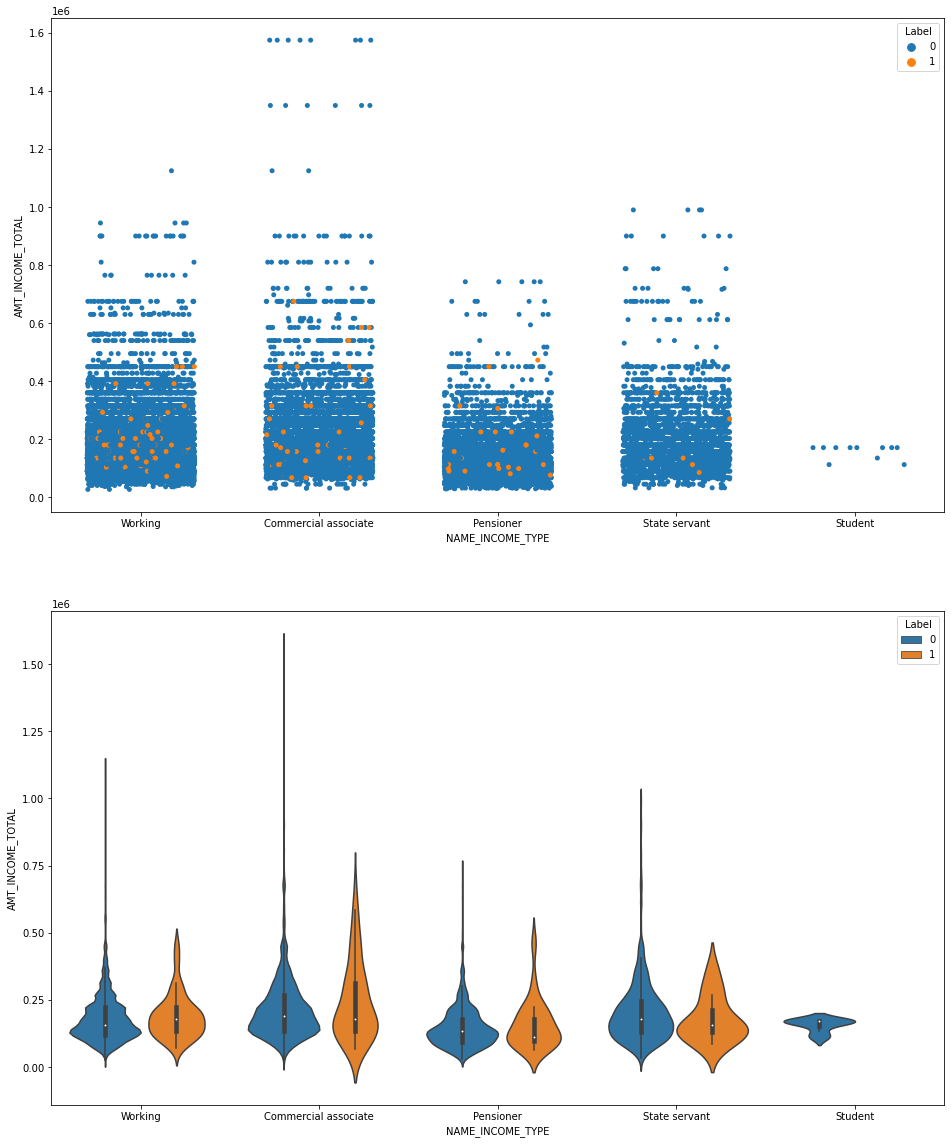

In [62]:
fig = plt.figure(figsize = (16,20))
ax1 = fig.add_subplot(2,1,1) 
sns.stripplot(x=new_data["NAME_INCOME_TYPE"], y = new_data["AMT_INCOME_TOTAL"], hue=new_data["Label"], jitter= 0.3, ax=ax1)
ax2 = fig.add_subplot(2,1,2) 
sns.violinplot(x=new_data["NAME_INCOME_TYPE"], y = new_data["AMT_INCOME_TOTAL"], hue=new_data["Label"],ax=ax2)

From the above plots, we can see that typically the bad customers are associated with low income (as stated also in the income analysis), and at the same time, the occupation only seems to lightly affect the default rates. Interestingly, Commercial associates who are more prone to defaulting also have a higher average income and many outliers.

### Education type

Continuing the EDA, we are exploring the education type.

In [63]:
unique_education = new_data["NAME_EDUCATION_TYPE"].unique()
print(unique_education)

['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


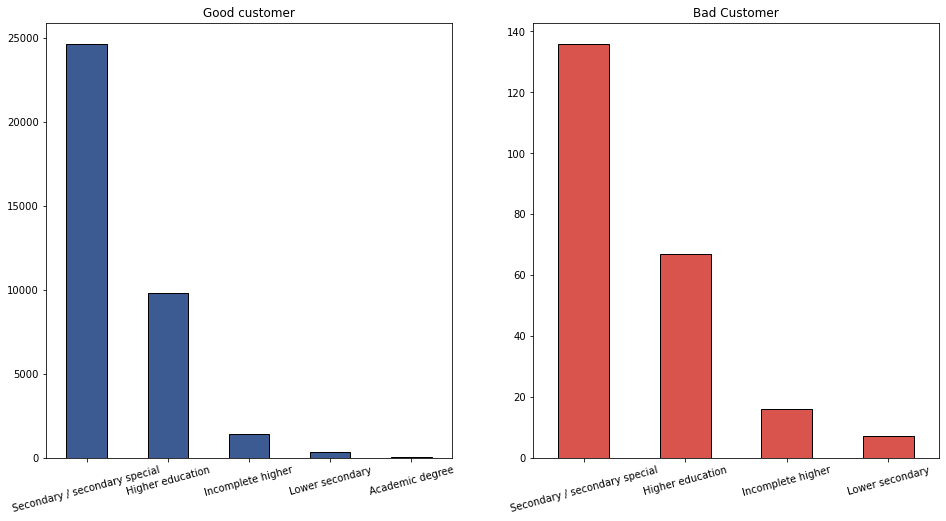

In [64]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols,figsize = (16,8))

for i,label in enumerate(unique_labels):
    new_data[new_data["Label"]==label]["NAME_EDUCATION_TYPE"].value_counts().plot(kind = "bar", rot = 15, ax = axes[i],color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label==0 else "Bad Customer")

It is also worth exploring the default rate percentage for each education type seperately

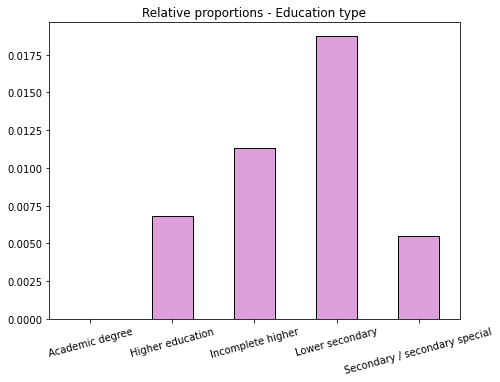

In [65]:
## Relative proportions graph
fig = plt.figure(figsize = (25,12))
ax1 = fig.add_subplot(2,3,1)
(new_data[new_data["Label"]==1]["NAME_EDUCATION_TYPE"].value_counts()/new_data["NAME_EDUCATION_TYPE"].value_counts()).plot(kind = "bar",ax = ax1, rot=15,edgecolor = "black",color = "plum")
ax1.set_title("Relative proportions - Education type")
plt.show()


**Observation** Lower secondary is by far the most prevelent in terms of defaulting rates. At the same time, academic degrees are associated with no defaults.

### Family status

In [66]:
unique_family = new_data["NAME_FAMILY_STATUS"].unique()
print(unique_family)

['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']


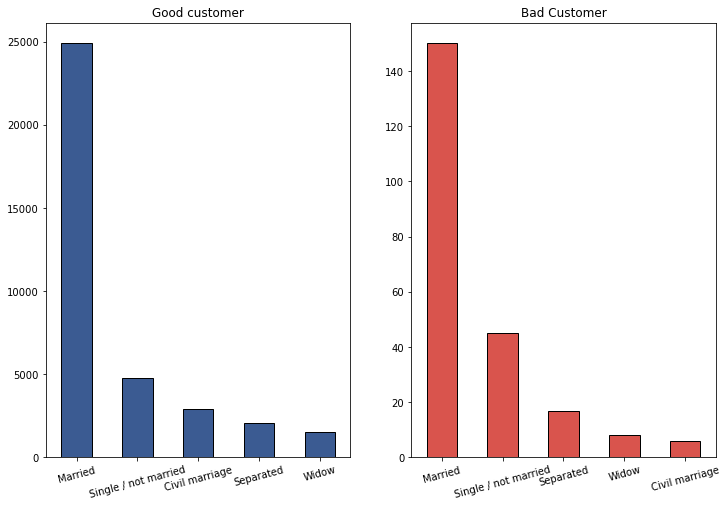

In [67]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols, figsize =(12,8))

for i,label in enumerate(unique_labels):
    new_data[new_data["Label"]==label]["NAME_FAMILY_STATUS"].value_counts().plot(kind = "bar",ax = axes[i],rot = 15,color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label ==0 else "Bad Customer")


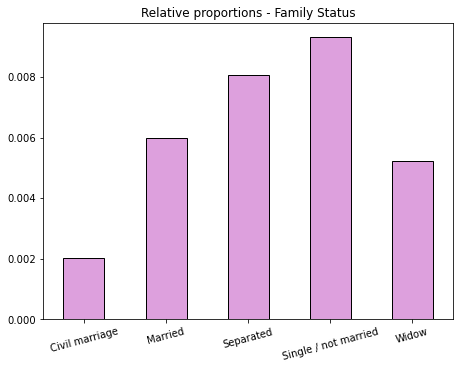

In [68]:
fig = plt.figure(figsize = (25,12))
ax1 = fig.add_subplot(2,3,1)
(new_data[new_data["Label"]==1]["NAME_FAMILY_STATUS"].value_counts()/new_data["NAME_FAMILY_STATUS"].value_counts()).plot(kind = "bar",rot = 15,edgecolor = "black",color = "plum")
ax1.set_title("Relative proportions - Family Status")
plt.show()

**Observation** Single people are more likely to default, while civil marriage are the least likely.

### Housing type

In [69]:
unique_housing = new_data["NAME_HOUSING_TYPE"].unique()
unique_housing

array(['Rented apartment', 'House / apartment', 'Municipal apartment',
       'With parents', 'Co-op apartment', 'Office apartment'],
      dtype=object)

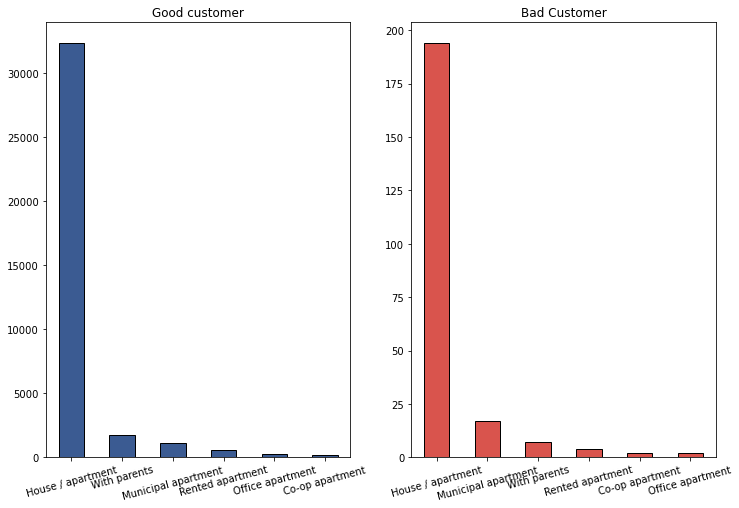

In [70]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols, figsize =(12,8))

for i,label in enumerate(unique_labels):
    new_data[new_data["Label"]==label]["NAME_HOUSING_TYPE"].value_counts().plot(kind = "bar",ax = axes[i],rot = 15,color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label ==0 else "Bad Customer")


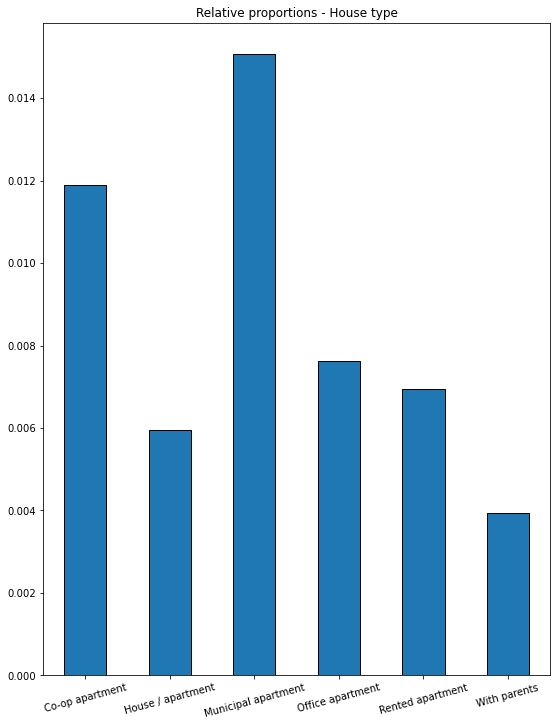

In [71]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(1,2,1)
(new_data[new_data["Label"]==1]["NAME_HOUSING_TYPE"].value_counts()/new_data["NAME_HOUSING_TYPE"].value_counts()).plot(kind = "bar", ax = ax1, rot = 15,edgecolor = "black")
ax1.set_title("Relative proportions - House type")
plt.show()

**Observation**: While the majority of people live in House/apartments, as a proportion the people who live in co-op apartments or municipal apartments are more likely to default. Simultaneously, people that live with their parents have the smallest chance to default, presumably due to their parents being able to help them with the doses or  possibly due the lack of rent expenses.

### Age (Days of Birth)

This variable is in the form of days since birth (Negative number). We will convert this to age in years. We could calculate the exact age for each person, but we do not know the exact date the data got extracted, and potentially it will not add too much value. Instead we will use the 365 days/year as a proxy.

In [72]:
## Division by 365 for years, rounding to the nearest integer and taking the absolute value.
new_data["DAYS_BIRTH"] = round(abs(new_data["DAYS_BIRTH"]/365),0)
new_data = new_data.rename(columns = {"DAYS_BIRTH":"Age"})

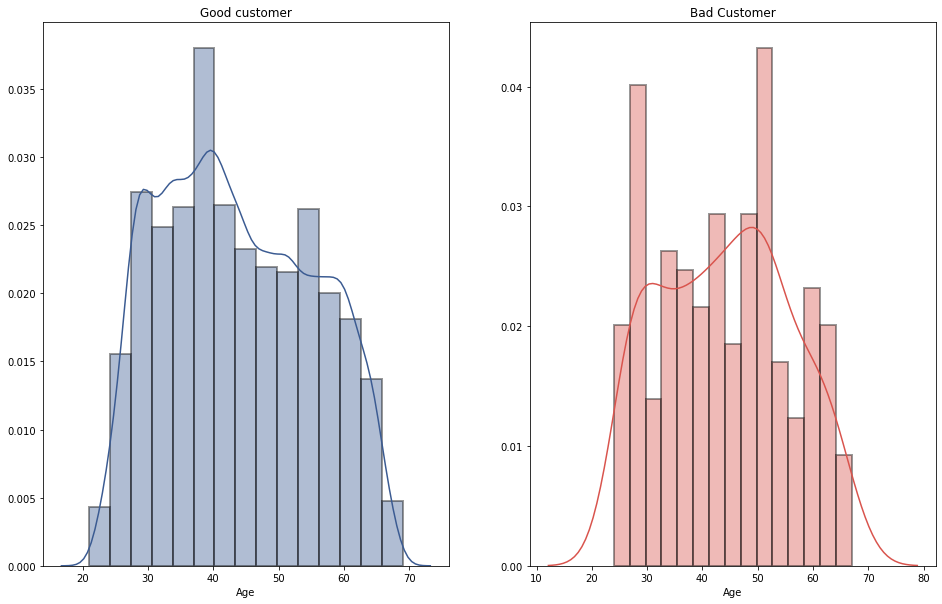

In [73]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols,figsize = (16,10))

for i,label in enumerate(unique_labels):
    sns.distplot(new_data[new_data["Label"]==label]["Age"],hist_kws=dict(edgecolor="k", linewidth=2),bins = 15, ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_title("Good customer" if label ==0 else "Bad Customer")

**Observation** People below 25 and above 65 do not seem to have bad credit score cases.

### Days Employed

Similarly to the age, this column is in days. We will convert it to years of employment.

In [74]:
new_data["DAYS_EMPLOYED"]= abs(round(new_data["DAYS_EMPLOYED"]/365))

In [75]:
new_data = new_data.rename(columns = {"DAYS_EMPLOYED": "Years of employment"})

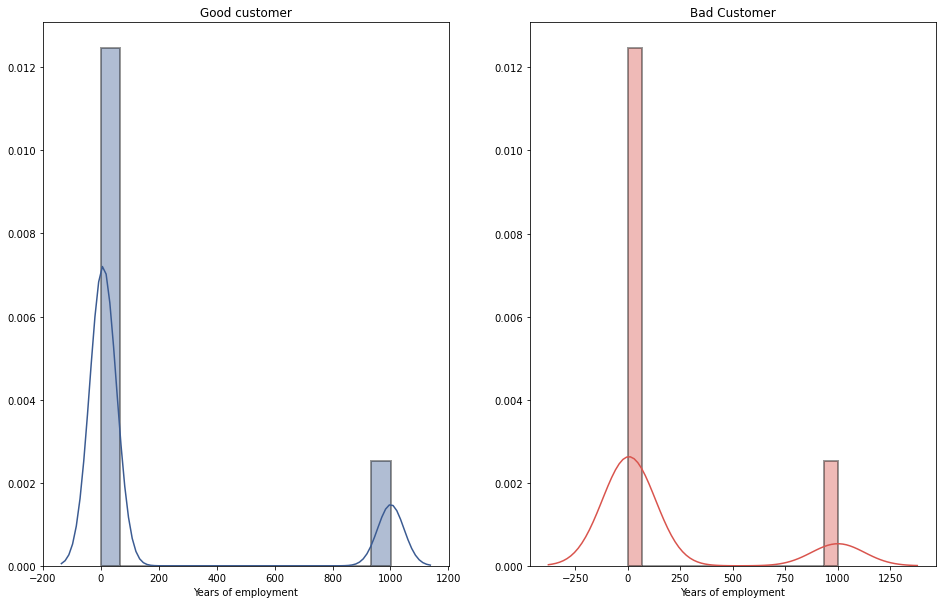

In [76]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols,figsize = (16,10))

for i,label in enumerate(unique_labels):
    sns.distplot(new_data[new_data["Label"]==label]["Years of employment"],hist_kws=dict(edgecolor="k", linewidth=2),bins = 15, ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_title("Good customer" if label ==0 else "Bad Customer")

Some of the data here appear to be of bad quality. We will deep dive and try to identify the cause. 

c:\users\mosch\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


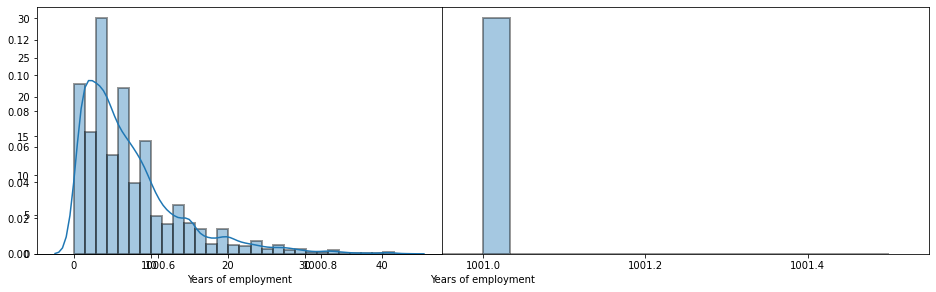

In [77]:
fig = plt.figure(figsize=(16,10))

ax1 = fig.add_subplot(2,1,1)
ax1 = sns.distplot(new_data[new_data["Years of employment"]>50]["Years of employment"],bins = 30,hist_kws=dict(edgecolor="k", linewidth=2))

ax2 = fig.add_subplot(221)
ax2 = sns.distplot(new_data[new_data["Years of employment"]<50]["Years of employment"],bins = 30,hist_kws=dict(edgecolor="k", linewidth=2))


All the employers that have more than 50 years of employment have one value 1001. Lets also look at their income type:

In [78]:
new_data[new_data["Years of employment"]>50]["NAME_INCOME_TYPE"].describe()

count          6135
unique            1
top       Pensioner
freq           6135
Name: NAME_INCOME_TYPE, dtype: object

Only pensioners have this strange years of employment value. Lets inspect all pensioners to see if this is true for all of them.

In [79]:
print("Number of pensioners that do not have 1001 as years of employment:",sum(new_data[new_data["NAME_INCOME_TYPE"]=="Pensioner"]["Years of employment"]!=1001))


Number of pensioners that do not have 1001 as years of employment: 17


Only 17 pensioners do not have the "1001" value. We are going to change the value of all pensioners to 50 which is the theoretical maximum age for retirement.

In [80]:
new_data["Years of employment"] = np.where(new_data["NAME_INCOME_TYPE"]=="Pensioner",50,new_data["Years of employment"])

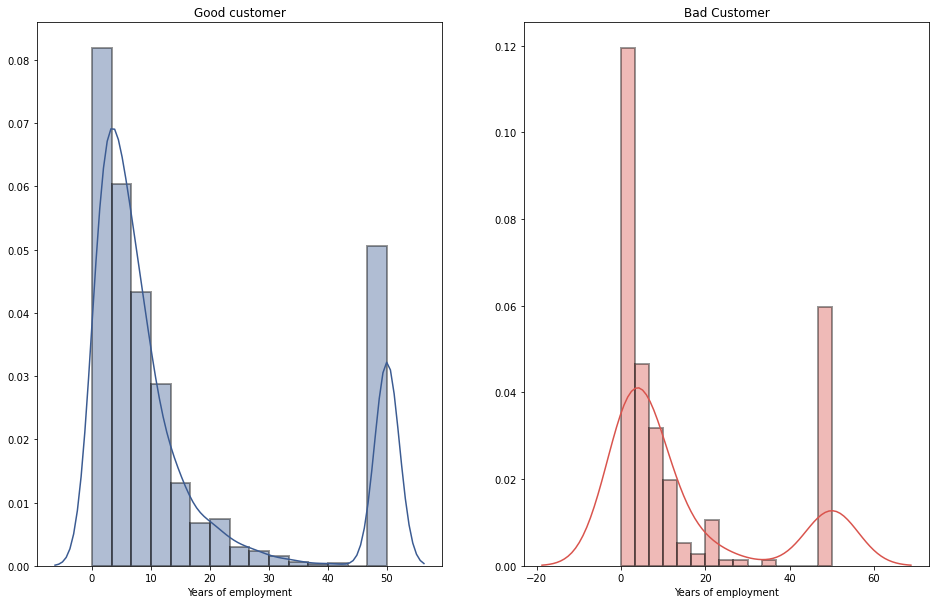

In [81]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols,figsize = (16,10))

for i,label in enumerate(unique_labels):
    sns.distplot(new_data[new_data["Label"]==label]["Years of employment"],hist_kws=dict(edgecolor="k", linewidth=2),bins = 15, ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_title("Good customer" if label ==0 else "Bad Customer")

Excluding the pensioners, the majority of people defaulting are their first years of employment, and the probability reduces as the years increase.

### Having a Cellphone

In [82]:
unique_cell = new_data["FLAG_MOBIL"].unique()
unique_cell

array([1.])

All applicants have a cellphone and therefore this variable is not useful for our analysis.

### Having a work phone

In [83]:
unique_work_cell = new_data["FLAG_WORK_PHONE"].unique()
unique_work_cell 

array([1., 0.])

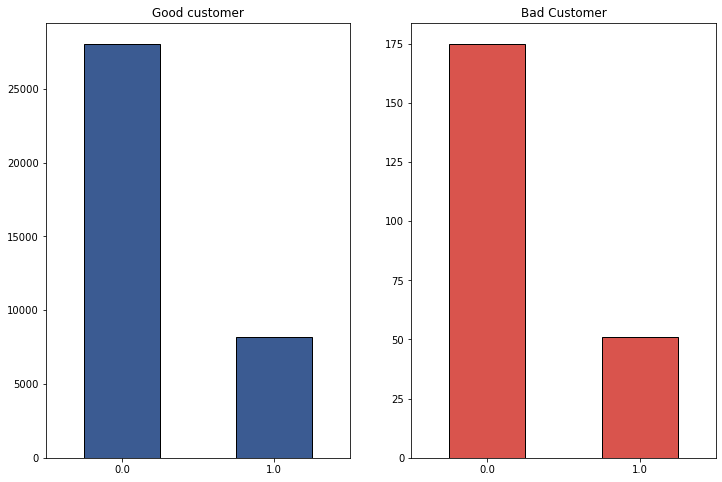

In [84]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols, figsize =(12,8))

for i,label in enumerate(unique_labels):
    new_data[new_data["Label"]==label]["FLAG_WORK_PHONE"].value_counts().plot(kind = "bar",ax = axes[i],rot = 0,color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label ==0 else "Bad Customer")


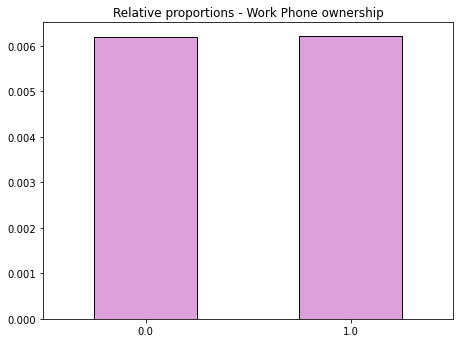

In [85]:
fig = plt.figure(figsize = (25,12))
ax1 = fig.add_subplot(2,3,1)
(new_data[new_data["Label"]==1]["FLAG_WORK_PHONE"].value_counts()/new_data["FLAG_WORK_PHONE"].value_counts()).plot(kind = "bar",rot = 0,edgecolor = "black",color = "plum")
ax1.set_title("Relative proportions - Work Phone ownership")
plt.show()

**Observation**: The variable does not seem to indicate any difference between users who are defaulting and otherwise.

### Having a phone

In [86]:
unique_phone = new_data["FLAG_PHONE"].unique()
print(unique_phone)

[0. 1.]


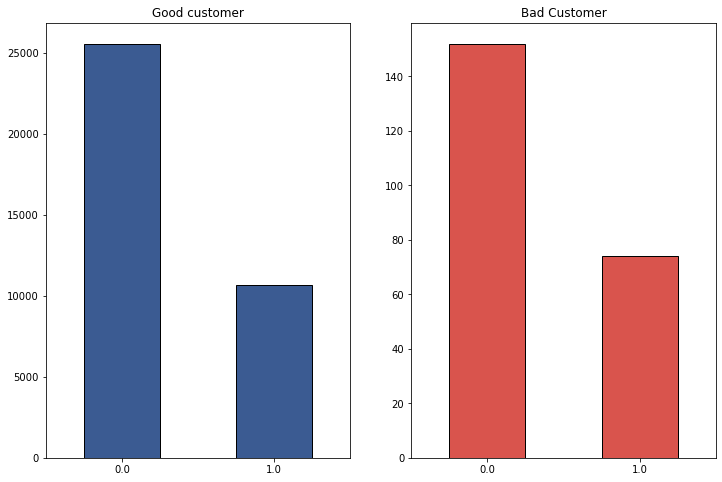

In [87]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols, figsize =(12,8))

for i,label in enumerate(unique_labels):
    new_data[new_data["Label"]==label]["FLAG_PHONE"].value_counts().plot(kind = "bar",ax = axes[i],rot = 0,color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label ==0 else "Bad Customer")


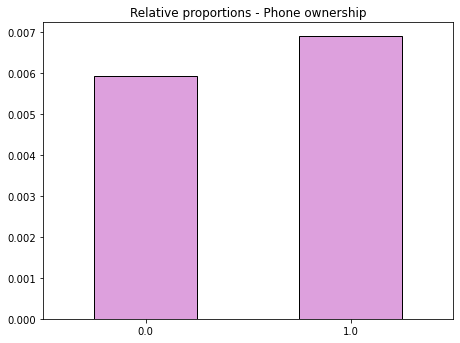

In [88]:
fig = plt.figure(figsize = (25,12))
ax1 = fig.add_subplot(2,3,1)
(new_data[new_data["Label"]==1]["FLAG_PHONE"].value_counts()/new_data["FLAG_PHONE"].value_counts()).plot(kind = "bar",rot = 0,edgecolor = "black",color = "plum")
ax1.set_title("Relative proportions - Phone ownership")
plt.show()

**Observation**: Having a phone is slightly more associated with bad default rates.

### Having email

In [89]:
unique_email = new_data["FLAG_PHONE"].unique()
print(unique_email)

[0. 1.]


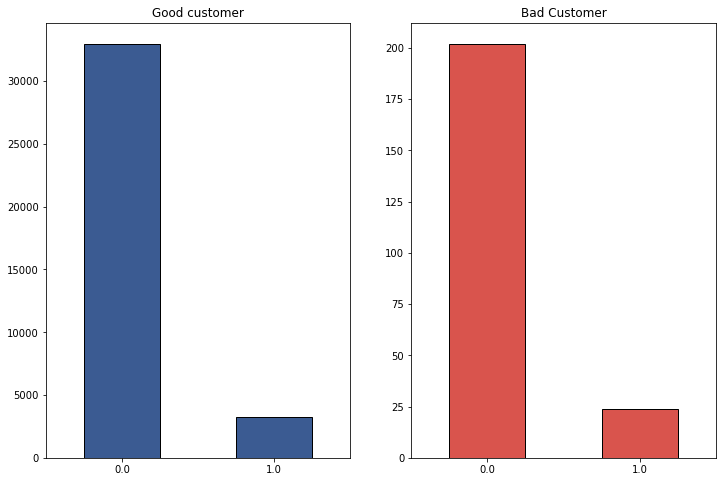

In [90]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols, figsize =(12,8))

for i,label in enumerate(unique_labels):
    new_data[new_data["Label"]==label]["FLAG_EMAIL"].value_counts().plot(kind = "bar",ax = axes[i],rot = 0,color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label ==0 else "Bad Customer")

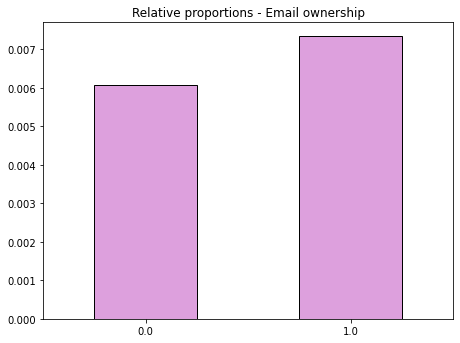

In [91]:
fig = plt.figure(figsize = (25,12))
ax1 = fig.add_subplot(2,3,1)
(new_data[new_data["Label"]==1]["FLAG_EMAIL"].value_counts()/new_data["FLAG_EMAIL"].value_counts()).plot(kind = "bar",rot = 0,edgecolor = "black",color = "plum")
ax1.set_title("Relative proportions - Email ownership")
plt.show()

**Observation**: Having an email is associated with slightly more default cases.

### Occupation type

In [92]:
unique_occupation = new_data["OCCUPATION_TYPE"].unique()
print(unique_occupation)

['Missing' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']


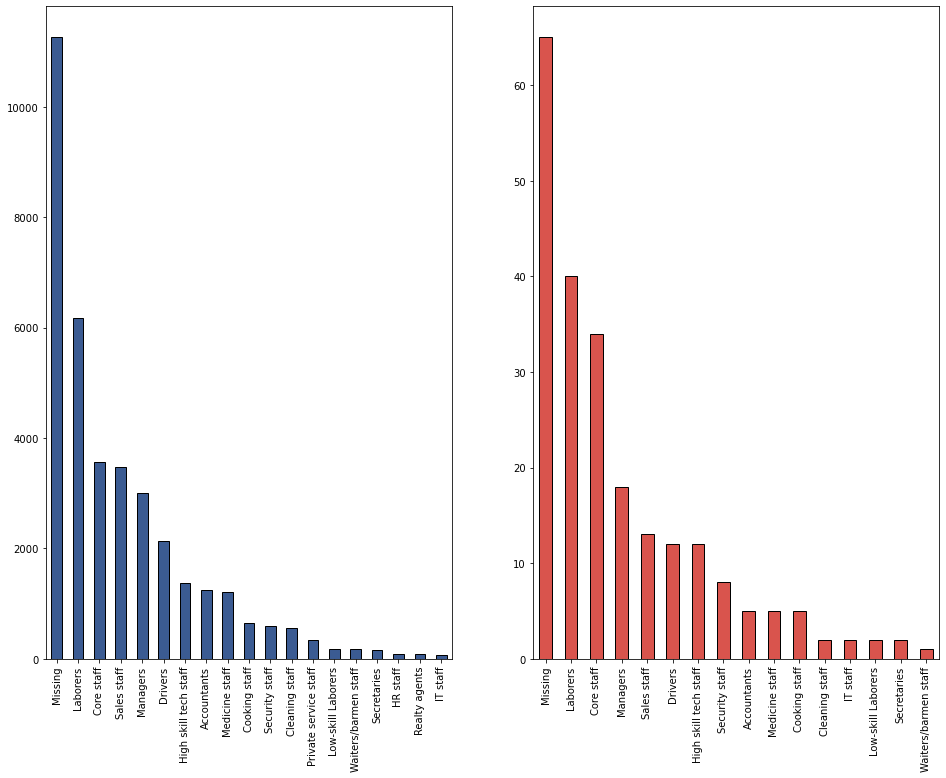

In [93]:
nrows = 1
ncols = 2

fig,axes = plt.subplots(nrows,ncols,figsize = (16,12))

for i,label in enumerate(unique_labels):
    new_data[new_data["Label"]==label]["OCCUPATION_TYPE"].value_counts().plot(kind = "bar", ax = axes[i],rot = 90,color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")

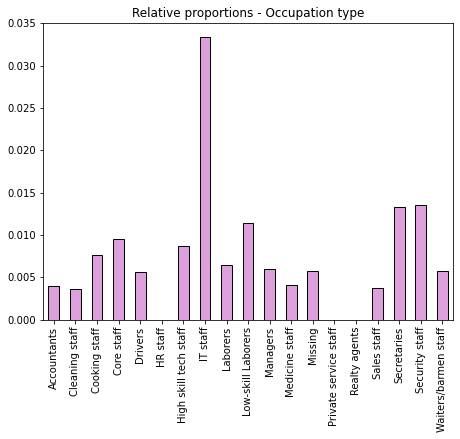

In [94]:
fig = plt.figure(figsize = (25,12))
ax1 = fig.add_subplot(2,3,1)
(new_data[new_data["Label"]==1]["OCCUPATION_TYPE"].value_counts()/new_data["OCCUPATION_TYPE"].value_counts()).plot(kind = "bar",rot = 90,edgecolor = "black",color = "plum")
ax1.set_title("Relative proportions - Occupation type")
plt.show()

**Observation**: IT staff is by far the riskiest group for defaulting. HR, Realty and Sales have no cases of defaulting.

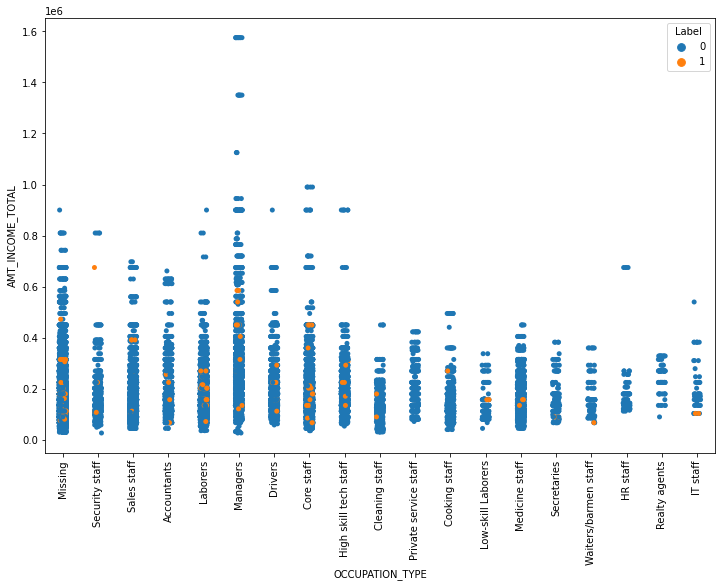

In [95]:
plt.figure(figsize=(12,8))
chart = sns.stripplot(x = new_data["OCCUPATION_TYPE"], y = new_data["AMT_INCOME_TOTAL"],hue=new_data["Label"],jitter=0.1)
chart.set_xticklabels(labels =chart.get_xticklabels() ,rotation=90)
plt.show()


**Observation**: Income in the categories with no default is not amongst the top earners. This may indicate less risky decisions in those professions.

### Number of family members

In [96]:
unique_family_members = new_data["CNT_FAM_MEMBERS"].unique()
print(unique_family_members)

[ 2.  1.  5.  3.  4.  6. 15.  7. 20.  9.]


Once again strange values exist in the dataset.

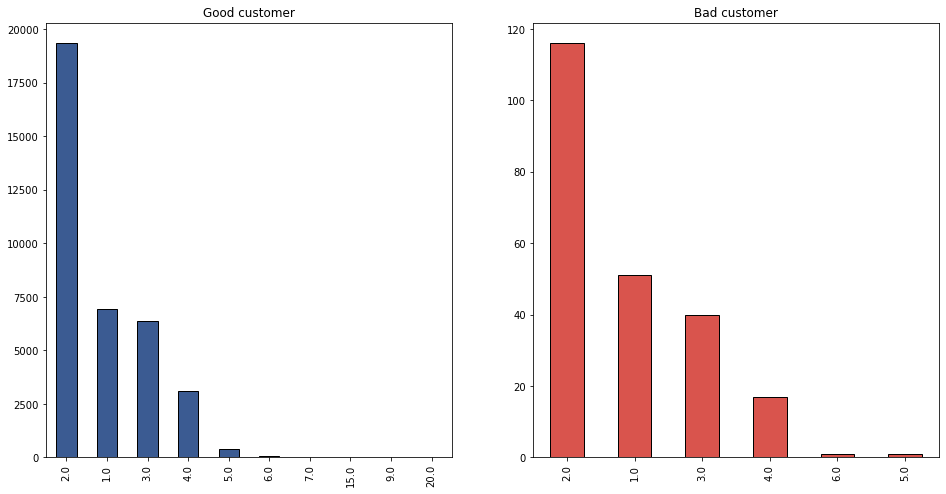

In [97]:
nrows = 1
ncols = len(unique_labels)

fig,axes = plt.subplots(nrows,ncols, figsize = (16,8))

for i,label in enumerate(unique_labels):
    new_data[new_data.Label == label].CNT_FAM_MEMBERS.value_counts().plot(kind = "bar",ax = axes[i],color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label == 0 else "Bad customer")

We will group all values above 5 as 5+.

In [98]:
new_data["CNT_FAM_MEMBERS"] = np.where(new_data["CNT_FAM_MEMBERS"]>=5,"5+",new_data["CNT_FAM_MEMBERS"])

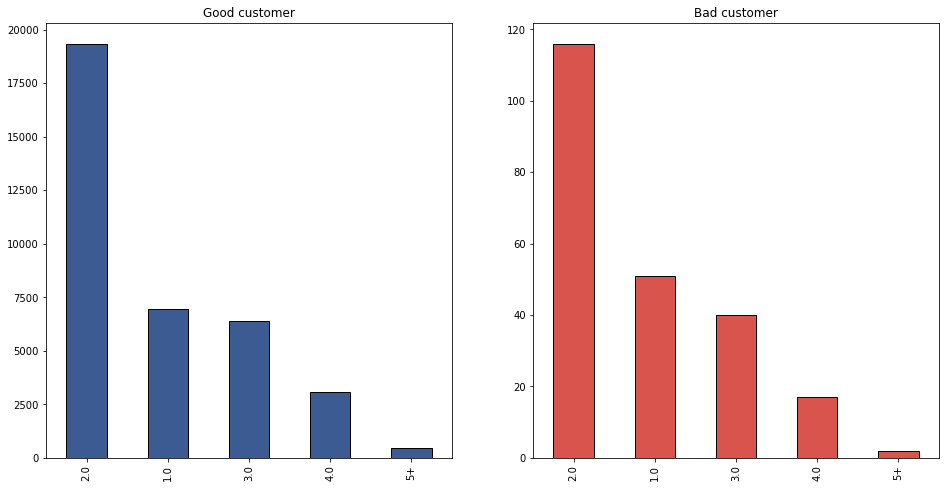

In [99]:
nrows = 1
ncols = len(unique_labels)

fig,axes = plt.subplots(nrows,ncols, figsize = (16,8))

for i,label in enumerate(unique_labels):
    new_data[new_data.Label == label].CNT_FAM_MEMBERS.value_counts().plot(kind = "bar",ax = axes[i],color = sns.xkcd_rgb[my_colors[i]],edgecolor = "black")
    axes[i].set_title("Good customer" if label == 0 else "Bad customer")

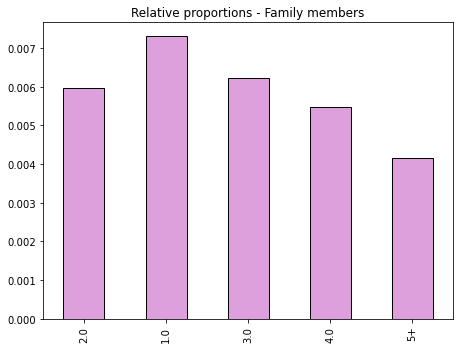

In [100]:
fig = plt.figure(figsize = (25,12))
ax1 = fig.add_subplot(2,3,1)
(new_data[new_data["Label"]==1]["CNT_FAM_MEMBERS"].value_counts()/new_data["CNT_FAM_MEMBERS"].value_counts()).plot(kind = "bar",rot = 90,edgecolor = "black",color = "plum")
ax1.set_title("Relative proportions - Family members")
plt.show()

**Observation**: While higher number of children is associated with higher risk of defaulting, higher number of family members is associated with a lower risk.

c:\users\mosch\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\mosch\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\mosch\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\mosch\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), U

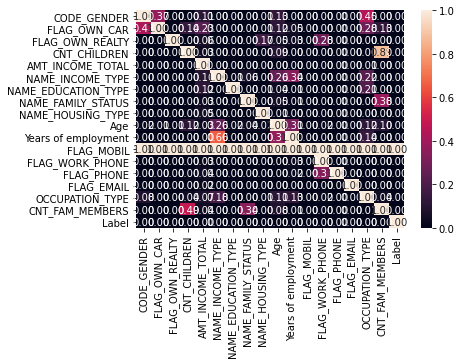

In [101]:
sns.heatmap(pps.matrix(new_data),annot=True,fmt=".2f")

## Feature selection

In [102]:
new_data = new_data.drop("FLAG_MOBIL",axis = 1)

In [103]:
Dummies = pd.get_dummies(new_data, columns=["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","FLAG_WORK_PHONE","FLAG_PHONE","FLAG_EMAIL","NAME_HOUSING_TYPE", "OCCUPATION_TYPE","CNT_CHILDREN","CNT_FAM_MEMBERS" ])

In [104]:
Dummies

,AMT_INCOME_TOTAL,Age,Years of employment,Label,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,CNT_CHILDREN_0.0,CNT_CHILDREN_1.0,CNT_CHILDREN_2.0,CNT_CHILDREN_3.0,CNT_CHILDREN_4+,CNT_FAM_MEMBERS_1.0,CNT_FAM_MEMBERS_2.0,CNT_FAM_MEMBERS_3.0,CNT_FAM_MEMBERS_4.0,CNT_FAM_MEMBERS_5+
0,427500.0,33.0,12.0,0,0,1,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
1,427500.0,33.0,12.0,0,0,1,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
2,112500.0,59.0,3.0,0,0,1,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
3,270000.0,52.0,8.0,0,1,0,1,0,0,1,...,1,0,0,0,0,1,0,0,0,0
4,270000.0,52.0,8.0,0,1,0,1,0,0,1,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,315000.0,48.0,7.0,1,0,1,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
36453,157500.0,34.0,4.0,1,1,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
36454,157500.0,34.0,50.0,1,1,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
36455,283500.0,49.0,2.0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0


## Fixing the class imbalance

Due to the class imbalance, we will first start by splitting into a t set (will be used for training) and a Rest set used for Cross validation and testing.

In [105]:
X_t,X_r,Y_t,Y_r = train_test_split(Dummies.drop(["Label"],axis = 1),Dummies["Label"],test_size = 0.2)

We resplit the Rest set equally to dev set (will be used for Cross validation) and test-set (will be used for evaluation of our model in new data).

In [106]:
Rest = pd.concat([X_r,Y_r],axis=1)

In [107]:
X_dev,X_test,Y_dev,Y_test = train_test_split(Rest.drop(["Label"],axis = 1),Rest["Label"],test_size = 0.5)

The final split of the data is 80%/10%/10% train/dev/test.

Now we upsample our train set to create balanced classes.

In [108]:
X_train, Y_train = SMOTE().fit_sample(X_t,Y_t)

In [109]:
print("Percentage of 'bad' customers in balanced dataset:",100*np.mean(Y_train),"%")

Percentage of 'bad' customers in balanced dataset: 50.0 %


We will now create a custom validation set (which comes from the same distribution as the test set) for our hyperparameter tuning.

In [110]:
train_ind = np.zeros((len(X_train)))
val_ind = np.zeros((len(X_dev)))


## Set all indexes of train set to -1:Not to be used and validation set to 0: To be used
for i in range(len(X_train)-1):
    train_ind[i] = -1

for i in range(len(X_dev)-1):
    val_ind[i] = 0

ps = PredefinedSplit(test_fold=np.concatenate((train_ind,val_ind)))
X_train = pd.concat([X_train,X_dev],axis = 0)
Y_train = pd.concat([Y_train,Y_dev],axis = 0)

## Model development and evaluation

### Logistic regression

In [111]:
Logit = LogisticRegression()
fit_log = Logit.fit(X_train,Y_train)

In [112]:
y_pred_log = pd.DataFrame(fit_log.predict(X_test))
confusion_matrix(y_pred_log,Y_test)

array([[3621,   25],
       [   0,    0]], dtype=int64)

In [113]:
Accuracy = {"Logistic":accuracy_score(y_pred_log,Y_test)}

In [114]:
Balanced_Accuracy = {"Logistic regression":balanced_accuracy_score(Y_test,y_pred_log)}

### Random Forest

In [115]:
param_grid = [{'n_estimators': range(100,1000,100)}]
RF = GridSearchCV(RandomForestClassifier(),param_grid,cv = ps,verbose=2)
fit_rf = RF.fit(X_train,Y_train)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total=   5.4s
[CV] n_estimators=200 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ................................. n_estimators=200, total=  12.2s
[CV] n_estimators=300 ................................................
[CV] ................................. n_estimators=300, total=  16.3s
[CV] n_estimators=400 ................................................
[CV] ................................. n_estimators=400, total=  18.9s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=  25.7s
[CV] n_estimators=600 ................................................
[CV] ................................. n_estimators=600, total=  29.0s
[CV] n_estimators=700 ................................................
[CV] ................................. n_estimators=700, total=  41.3s
[CV] n_estimators=800 ................................................
[CV] ................................. n_estimators=800, total=  46.0s
[CV] n_estimators=900 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.0min finished


In [116]:
y_pred_rf = pd.DataFrame(fit_rf.predict(X_test))

In [117]:
confusion_matrix(y_pred_rf,Y_test)

array([[3614,   19],
       [   7,    6]], dtype=int64)

In [118]:
Accuracy["Random Forest"] = accuracy_score(Y_test,y_pred_rf)

In [119]:
Balanced_Accuracy["Random Forest"] = balanced_accuracy_score(Y_test,y_pred_rf)

### XG Boost

In [ ]:
param_grid = [{'n_estimators': range(500,1000,100)}]

In [ ]:
xgb = GridSearchCV(XGBClassifier(nthread = -1),param_grid,cv = ps,verbose=2)
fit_xgb = xgb.fit(X_all,Y_all)

In [ ]:
y_pred = pd.DataFrame(fit_xgb.predict(X_test))
confusion_matrix(y_pred,Y_test)

In [ ]:
xgb = GridSearchCV(XGBClassifier(nthread = -1),param_grid,cv = 5,verbose=2)
fit_xgb = xgb.fit(X_all,Y_all)

In [ ]:
y_pred = pd.DataFrame(fit_xgb.predict(X_test))
confusion_matrix(y_pred,Y_test)

In [ ]:
param_grid = {'max_depth': range(4,6),
              'n_estimators': range(500,1000,100)}

In [ ]:
xgb = GridSearchCV(XGBClassifier(nthread = -1),param_grid,cv = 5,verbose=2)

fit_xgb = xgb.fit(X_train,Y_train)

y_pred = pd.DataFrame(fit_xgb.predict(X_test))

In [ ]:
fit_xgb.best_params_

In [ ]:
xg = XGBClassifier()

fit_xgb = xg.fit(X_train,Y_train)

y_pred = pd.DataFrame(fit_xgb.predict(X_test))


In [ ]:
confusion_matrix(y_pred,Y_test)

In [ ]:
accuracy_score(y_pred,Y_test)

In [ ]:
y_pred = pd.DataFrame(fit_xgb.predict(X_test1))
confusion_matrix(y_pred,Y_test1)

In [ ]:
accuracy_score(y_pred,Y_test1)